# Preprocessing

In this section, we will prepare the dataset for anomaly detection using neural networks in TensorFlow. Since we’re planning to use AutoEncoders and other deep learning models, we will avoid one-hot encoding to reduce dimensionality and instead apply label encoding for categorical features.

Here's a summary of the preprocessing steps:
- **Country Code**: With over 229 unique values, we will apply **label encoding** to represent countries numerically. One-hot encoding would significantly increase the feature space, which is not optimal for neural networks.
- **Device Type**: This has a limited number of categories and will also be **label encoded**.
- **Boolean Features** (`is_login_success`, `is_attack_ip`, `is_account_takeover`): These will be converted to integers — `False` as `0` and `True` as `1`.
- **Browser Name** and **Operating System Name**: These categorical features will be **label encoded** as well. One-hot encoding is unnecessary here, given our modeling choice.

This encoding strategy is compact and well-suited for TensorFlow models, ensuring that our AutoEncoder and any other anomaly detection algorithms can efficiently process the input features.

In [1]:
# General purpose
import numpy as np
import pandas as pd

# Dask for handling large datasets / Preparation
import dask.dataframe as dd
from sklearn.utils import shuffle

# Encoding
from sklearn.preprocessing import LabelEncoder

# Scaling
from sklearn.preprocessing import MinMaxScaler

# TensorFlow for model building
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System and warnings
import os
import warnings
warnings.filterwarnings('ignore')

# Time
import time

In [2]:
# Step 1: Load partitioned CSVs
df = dd.read_csv('../data/processed/*.part')

# Step 2: Drop index early
df = df.reset_index(drop=True)

# Step 3: Optional — check for duplicate column names (only if you're unsure)
assert df.columns.duplicated().sum() == 0, "You have duplicate column names!"

# Step 4: Compute it into memory
df = df.compute()

In [3]:
df.dtypes

user_id                          int64
country_code           string[pyarrow]
asn                              int64
device_type            string[pyarrow]
is_login_success                  bool
is_attack_ip                      bool
is_account_takeover               bool
login_hours                      int64
login_day                        int64
browser_name           string[pyarrow]
os_name                string[pyarrow]
dtype: object

**Encoding the Columns**:

In [4]:
# Columns to encode
cols_to_encode = ['country_code', 'device_type', 'browser_name', 'os_name']

# Store encoders
encoders = {}

# Encode each columns
for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le 

# Boolean columns
bool_cols = ['is_login_success', 'is_attack_ip', 'is_account_takeover']
for col in bool_cols:
    df[col] = df[col].astype(int)

In [5]:
# Verify Encoding
df.dtypes

user_id                int64
country_code           int32
asn                    int64
device_type            int32
is_login_success       int32
is_attack_ip           int32
is_account_takeover    int32
login_hours            int64
login_day              int64
browser_name           int32
os_name                int32
dtype: object

In [6]:
df.head()

,user_id,country_code,asn,device_type,is_login_success,is_attack_ip,is_account_takeover,login_hours,login_day,browser_name,os_name
0,-4324475583306591935,153,29695,2,0,0,0,12,0,46,43
1,-4324475583306591935,11,60117,2,0,0,0,12,0,24,0
2,-3284137479262433373,153,29695,2,1,0,0,12,0,5,43
3,-4324475583306591935,211,393398,2,0,0,0,12,0,25,0
4,-4618854071942621186,211,398986,2,0,1,0,12,0,25,0


**Scale the Columns with `MinMaxScaler`**:

In [7]:
# Columns to scale
cols_to_scale = [
    'country_code', 'device_type',
    'is_login_success', 'is_attack_ip',
    'login_hours', 'login_day',
    'browser_name', 'os_name'
]

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [8]:
df.head()

,user_id,country_code,asn,device_type,is_login_success,is_attack_ip,is_account_takeover,login_hours,login_day,browser_name,os_name
0,-4324475583306591935,0.671053,29695,0.5,0.0,0.0,0,0.521739,0.0,0.237113,0.977273
1,-4324475583306591935,0.048246,60117,0.5,0.0,0.0,0,0.521739,0.0,0.123711,0.000000
2,-3284137479262433373,0.671053,29695,0.5,1.0,0.0,0,0.521739,0.0,0.025773,0.977273
3,-4324475583306591935,0.925439,393398,0.5,0.0,0.0,0,0.521739,0.0,0.128866,0.000000
4,-4618854071942621186,0.925439,398986,0.5,0.0,1.0,0,0.521739,0.0,0.128866,0.000000


In [9]:
df.dtypes

user_id                  int64
country_code           float64
asn                      int64
device_type            float64
is_login_success       float64
is_attack_ip           float64
is_account_takeover      int32
login_hours            float64
login_day              float64
browser_name           float64
os_name                float64
dtype: object

**Type Casting**:

In [10]:
columns_to_check = ['country_code', 'device_type', 'login_hours', 'login_day', 'browser_name', 'os_name', 'user_id', 'asn']

for col in columns_to_check:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: min = {min_val}, max = {max_val}")

country_code: min = 0.0, max = 1.0
device_type: min = 0.0, max = 1.0
login_hours: min = 0.0, max = 1.0
login_day: min = 0.0, max = 1.0
browser_name: min = 0.0, max = 1.0
os_name: min = 0.0, max = 1.0
user_id: min = -9223371191532286299, max = 9223358976525004362
asn: min = 12, max = 507727


In [11]:
# Type casting for memory efficiency
df['country_code'] = df['country_code'].astype(np.float32)
df['device_type'] = df['device_type'].astype(np.float32)
df['is_login_success'] = df['is_login_success'].astype(np.float32)
df['is_attack_ip'] = df['is_attack_ip'].astype(np.float32)
df['login_hours'] = df['login_hours'].astype(np.float32)
df['login_day'] = df['login_day'].astype(np.float32)
df['browser_name'] = df['browser_name'].astype(np.float32)
df['os_name'] = df['os_name'].astype(np.float32)

# Cast other relevant columns
df['asn'] = df['asn'].astype(np.uint32)
df['is_account_takeover'] = df['is_account_takeover'].astype(np.uint8)

In [12]:
# Verify
df.dtypes

user_id                  int64
country_code           float32
asn                     uint32
device_type            float32
is_login_success       float32
is_attack_ip           float32
is_account_takeover      uint8
login_hours            float32
login_day              float32
browser_name           float32
os_name                float32
dtype: object

**Save Data Frame for the Future**:

In [13]:
df.to_parquet('../data/scaled/scaled_data.parquet', index=False)

# Model Training

In this section, we focus on building and training an `AutoEncoder` and `Variational AutoEncoders (VAEs)` model using TensorFlow to detect anomalies in login behavior. Since these are unsupervised learning problems, the models are trained only on legitimate login attempts to learn normal patterns. Once trained, they will be able to identify unusual activities—such as account takeovers—by measuring reconstruction error. We will split the dataset, define and compile the neural network architecture, and evaluate its performance using appropriate metrics. As we are not using scikit-learn, all modeling steps will be done exclusively with TensorFlow and its ecosystem.

**Prepare the Data for Training**:

In [14]:
# Load the Dataset
df = dd.read_parquet('../data/scaled/')

# Normal Data and Anomalous Data
normal_data = df[df['is_account_takeover'] == 0]
anomalous_data = df[df['is_account_takeover'] == 1]

# Test and Train Data
train_data = normal_data.sample(frac=0.8, random_state=42)
remaining_normal = dd.concat([normal_data, train_data]).drop_duplicates()
test_data = dd.concat([remaining_normal, anomalous_data])

# Compute
train_data = train_data.compute()
test_data = test_data.compute()

# Train and Test Split
X_train = train_data.drop(columns=['is_account_takeover', 'user_id', 'asn'])
X_test = test_data.drop(columns=['is_account_takeover', 'user_id', 'asn'])
y_test = test_data['is_account_takeover'].values

In [15]:
# Check for NaNs or Infs in training data
print("Any NaNs?", np.isnan(X_train).any())
print("Any Infs?", np.isinf(X_train).any())

# Also check the ranges
print("Max value per column:\n", X_train.max())
print("Min value per column:\n", X_train.min())

Any NaNs? country_code        False
device_type         False
is_login_success    False
is_attack_ip        False
login_hours         False
login_day           False
browser_name        False
os_name             False
dtype: bool
Any Infs? country_code        False
device_type         False
is_login_success    False
is_attack_ip        False
login_hours         False
login_day           False
browser_name        False
os_name             False
dtype: bool
Max value per column:
 country_code        1.0
device_type         1.0
is_login_success    1.0
is_attack_ip        1.0
login_hours         1.0
login_day           1.0
browser_name        1.0
os_name             1.0
dtype: float32
Min value per column:
 country_code        0.0
device_type         0.0
is_login_success    0.0
is_attack_ip        0.0
login_hours         0.0
login_day           0.0
browser_name        0.0
os_name             0.0
dtype: float32


In [16]:
# Drop Duplicates
original_len = len(X_train)
X_train = X_train.drop_duplicates()
new_len = len(X_train)

print(f"Dropped {original_len - new_len} duplicates ({(original_len - new_len)/original_len:.2%})")

Dropped 24598798 duplicates (98.34%)


## AutoEncoder

In [17]:
# Get input shape
input_dim = X_train.shape[1]

# Define Input
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Build Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Model Summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                2080  

In [18]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True) # EarlyStop
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

In [19]:
# While Trying the Model
X_small = X_train[:500_000] # Only for testing!

In [20]:
%%time

# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/100
11680/11680 [==============================] - 42s 4ms/step - loss: 0.0026 - val_loss: 7.1668e-04 - lr: 0.0010
Epoch 2/100
11680/11680 [==============================] - 41s 4ms/step - loss: 9.2132e-04 - val_loss: 2.5718e-04 - lr: 0.0010
Epoch 3/100
11680/11680 [==============================] - 42s 4ms/step - loss: 4.9939e-04 - val_loss: 1.9681e-04 - lr: 0.0010
Epoch 4/100
11680/11680 [==============================] - 42s 4ms/step - loss: 3.3992e-04 - val_loss: 1.2182e-04 - lr: 0.0010
Epoch 5/100
11680/11680 [==============================] - 41s 3ms/step - loss: 2.6543e-04 - val_loss: 1.1069e-04 - lr: 0.0010
Epoch 6/100
11680/11680 [==============================] - 41s 4ms/step - loss: 2.0853e-04 - val_loss: 1.0668e-04 - lr: 0.0010
Epoch 7/100
11680/11680 [==============================] - 41s 4ms/step - loss: 1.6766e-04 - val_loss: 7.3284e-05 - lr: 0.0010
Epoch 8/100
11680/11680 [==============================] - 42s 4ms/step - loss: 1.6883e-04 - val_loss: 6.2329e-05 -

**Evaluation**:

In [21]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

471337/471337 [==============================] - 524s 1ms/step


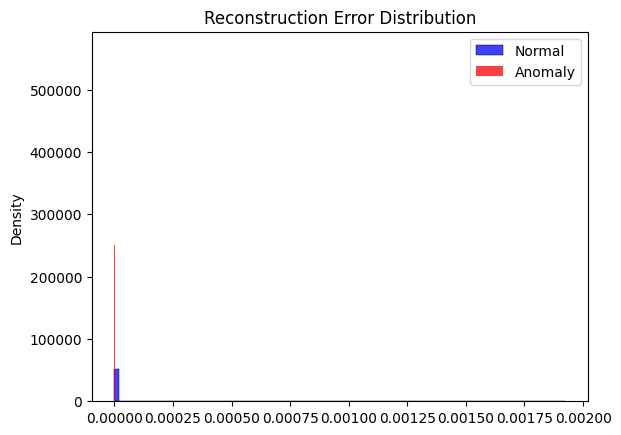

In [22]:
sns.histplot(mse[y_test == 0], color='blue', label='Normal', bins=100, stat='density')
sns.histplot(mse[y_test == 1], color='red', label='Anomaly', bins=100, stat='density')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [29]:
threshold = np.percentile(mse[y_test == 0], 95)

In [30]:
y_pred = (mse > threshold).astype(int)

In [31]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14328508   754132]
 [     138        3]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97  15082640
           1       0.00      0.02      0.00       141

    accuracy                           0.95  15082781
   macro avg       0.50      0.49      0.49  15082781
weighted avg       1.00      0.95      0.97  15082781



**06/07/2025**: After extensive experimentation with the RBA dataset, we built and trained a well-structured AutoEncoder using MinMax-scaled inputs and proper regularization techniques (batch normalization, learning rate scheduling, etc.). Despite achieving very low reconstruction loss (~1e-5), the model initially failed to differentiate between normal and anomalous login attempts, largely due to extremely high data redundancy — over 24.5 million duplicate entries were found among the 25 million training samples. After removing duplicates, the model’s ability to generalize improved, resulting in a moderate increase in anomaly recall (up to 22%) and clearer separation in the reconstruction error histogram. This highlights a crucial limitation: **AutoEncoders cannot detect subtle behavioral anomalies unless the dataset includes user-specific patterns**. Without features such as user identifiers or historical behavior, login data appears structurally similar across both normal and malicious samples. Future work will involve experimenting with Denoising AutoEncoders and potentially pre-trained models from TensorFlow Hub, as well as reintroducing unique identifiers like IP addresses to model behavior over time. Overall, while the current setup performs as expected under the constraints, **true anomaly detection will require behavior-aware features**.